In [ ]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from PIL import Image
from io import BytesIO
import cv2

# Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

subscription_key = "0dea9d588d4e464086a0c0f89fa747a2"
endpoint = "https://xuanhai.cognitiveservices.azure.com/"

ocr_url = endpoint + "vision/v3.1/ocr"

# Set image_url to the URL of an image that you want to analyze.
# image_url = "https://drive.google.com/file/d/1fm-pSZpg68ROHjrA_NlyWOgS1I8_LRth"
# image_path = "338px-Atomist_quote_from_Democritus.png"
# headers = {'Ocp-Apim-Subscription-Key': subscription_key}
# params = {'language': 'unk', 'detectOrientation': 'true'}
# data = {'url': image_url}
# response = requests.post(ocr_url, headers=headers, params=params, json=data)
# response.raise_for_status()

image_path = "../data/google_img/gg_img29.jpg"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
params = {'language': 'unk', 'detectOrientation': 'true'}
# put the byte array into your post request
response = requests.post(ocr_url, headers=headers, params=params, data = image_data)
response.raise_for_status()

analysis = response.json()

# Extract the word bounding boxes and text.
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
            


In [ ]:
# # Display the image and overlay it with the extracted text.
# plt.figure(figsize=(5, 5))
# # image = Image.open(BytesIO(requests.get(image_url).content))
# image = cv2.imread(image_path)

# fig = plt.figure(figsize=(16,16))

# ax = plt.imshow(image, alpha=0.5)

# for para in line_infos:
#     for line in para:
#         bbox = [int(num) for num in line["boundingBox"].split(",")]
#     #     text = word["text"]
#         origin = (bbox[0], bbox[1])
#         patch = Rectangle(origin, bbox[2], bbox[3],
#                           fill=False, linewidth=2, color='r')
#         ax.axes.add_patch(patch)
# #     plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
    
# plt.show()
# plt.axis("off")

In [ ]:
analysis

In [ ]:
analysis

In [189]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO
import cv2
import json
import time

subscription_key = "0dea9d588d4e464086a0c0f89fa747a2"
endpoint = "https://xuanhai.cognitiveservices.azure.com/"

# ocr_api_url = endpoint + "vision/v3.1/ocr"
ocr_api_url = endpoint + "/vision/v3.1/read/analyze"

# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
params = {'language': 'unk',
#           'detectOrientation': 'true'
         }

In [289]:
def get_lines_bounding(response_json):
    line_boxes = []
    lines = [{'boundingBox': line['boundingBox'], 'words': line['words']} for region in response_json["regions"] for line in region["lines"]]
#     return lines
    for line in lines:
        bbox = [int(num) for num in line['boundingBox'].split(",")]
        text = ' '.join([word['text'] for word in line['words']])
        line_boxes.append({'boundingBox': bbox, 'text': text})
        
    return line_boxes

def save_json(obj, full_file_path):
    with open(full_file_path, 'w', encoding='utf8') as file:
        json.dump(obj, file, indent=2, ensure_ascii=False)
        
def drop_extension(file_path):
    """
    Drop file extension of a file path.
    """
    return os.path.splitext(file_path)[0]

def get_file_path_by_type(path, extensions=['.jpg', '.png']):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(path + '/' + x)
    
    return img_paths

def get_all_files(path):
    file_paths = []
    for x in os.listdir(path):
        file_paths.append(path + '/' + x)
    
    return file_paths

def request_azure_ocr(image_data):
    response = requests.post(ocr_api_url, headers=headers, 
                         params=params, 
                         data = image_data)
    response.raise_for_status()

    analysis = response.json()
    
    return analysis
        
def request_azure_read_api(image_data):
    text_recognition_url = endpoint + "/vision/v3.1/read/analyze"

    headers = {'Ocp-Apim-Subscription-Key': subscription_key,
              'Content-Type': 'application/octet-stream'
              }

    response = requests.post(
        text_recognition_url, headers=headers,
    #     json=data,
        data = image_data
    )

    response.raise_for_status()

    # Extracting text requires two API calls: One call to submit the
    # image for processing, the other to retrieve the text found in the image.

    # Holds the URI used to retrieve the recognized text.
    operation_url = response.headers["Operation-Location"]

    # The recognized text isn't immediately available, so poll to wait for completion.
    analysis = {}
    poll = True
    while (poll):
        response_final = requests.get(
            response.headers["Operation-Location"], headers=headers)
        analysis = response_final.json()

    #     print(json.dumps(analysis, indent=4))

        time.sleep(0.01)  # wait for completion
        if ("analyzeResult" in analysis):
            poll = False
        if ("status" in analysis and analysis['status'] == 'failed'):
            poll = False
            
    return analysis

def get_line_polygons_read_api(analysis):
    polygons = []
    if ("analyzeResult" in analysis):
        # Extract the recognized text, with bounding boxes.
        polygons = [{"boundingBox": line["boundingBox"], "text": line["text"]}
                         for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
        
    return polygons

def show_polygons(image, polygons: dict, figsize=(16,16), line_color='y'):
    plt.figure(figsize=figsize)
    ax = plt.imshow(image)
    for polygon in polygons:
        bound = polygon["boundingBox"]
        vertices = [(bound[i], bound[i+1])
                    for i in range(0, len(bound), 2)]
        text = polygon['text']
        patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color=line_color)
        ax.axes.add_patch(patch)
    #     plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
    plt.show()

In [290]:
def azure_ocr(img_path, sleep=0.01, overide=False):
    """
    sleep: second
    """
    img_path_list = get_file_path_by_type(img_path, extensions=['.jpg', '.png'])
    all_files = get_all_files(img_path)
    
    logs = []
#     print(img_path_list)
    for img_path in img_path_list:
        print(img_path) 
        img_name = drop_extension(img_path)
        line_file_name = img_name + '_lines' + '.json'
        response_file_name = img_name + '_response' + '.json'
        
        if (not overide) and (line_file_name in all_files) and (response_file_name in all_files):
            continue
        
        print('requesting...')
        
        try:
            # Read the image into a byte array
            image_data = open(img_path, "rb").read()
            
            # put the byte array into your post request
            analysis = request_azure_read_api(image_data)

            lines = get_lines_bounding(analysis)
            
            save_json(lines, line_file_name)
            save_json(analysis, response_file_name)

        except Exception as e:
            print('error at: %s' % img_path)
            logs.append(str(e) + ', file:' + img_path)
            
        time.sleep(sleep)
        
    print('done!')

    return logs

def azure_read(img_path, sleep=0.01, overide=False):
    """
    sleep: second
    """
    img_path_list = get_image_path(img_path)
    all_files = get_all_files(img_path)
    
    logs = []
#     print(img_path_list)
    for i, img_path in enumerate(img_path_list):
#         if i < 553:
#             continue  # skip what have done
            
        print("Number %d: "%i, img_path) 
        img_name = drop_extension(img_path)
        line_file_name = img_name + '_lines' + '.json'
        response_file_name = img_name + '_response' + '.json'
        
        if (not overide) and (line_file_name in all_files) and (response_file_name in all_files):
            continue
        
        print('requesting...')
        
        try:
            # Read the image into a byte array
            img_data = open(img_path, "rb").read()
            
            # put the byte array into your post request            
            analysis = request_azure_read_api(img_data)

            lines = get_line_polygons_read_api(analysis)
            
            save_json(lines, line_file_name)
            save_json(analysis, response_file_name)

        except Exception as e:
            print('error at: %s' % img_path)
            logs.append(str(e) + ', file:' + img_path)
            
        time.sleep(sleep)
        
    print('done!')

    return logs

In [ ]:
# img_path =  
# azure_read("../data/google_img/", overide=True)

In [ ]:
# img_path = "../data/train_images/hung"
# azure_ocr(img_path, sleep=0.05)

In [ ]:
# img_path = "../data/train_images/tu"
# azure_ocr(img_path, sleep=0.05)

In [ ]:
# img_path = "../data/train_images/nam"
# azure_ocr(img_path, sleep=0.05)

In [ ]:
# img_path = "../data/train_images/nam_8.12.2020/"
# azure_ocr(img_path, sleep=0.01)

In [272]:
img_path = "../data/train_images/data_labeled_read/"
logs = azure_read(img_path, sleep=0.01, overide=True)

Number 0:  ../data/train_images/data_labeled_read//01-2011-tt-btttt.pdf0.jpg
requesting...
Number 1:  ../data/train_images/data_labeled_read//01-2011-tt-btttt.pdf1.jpg
requesting...
Number 2:  ../data/train_images/data_labeled_read//01_VBHN_BGDDT.signed.pdf1.jpg
requesting...
Number 3:  ../data/train_images/data_labeled_read//01_VBHN_BGDDT.signed.pdf2.jpg
requesting...
Number 4:  ../data/train_images/data_labeled_read//02_VBHN_BGDDT.signed.pdf2.jpg
requesting...
Number 5:  ../data/train_images/data_labeled_read//03-2013-tt-btttt.signed.pdf0.jpg
requesting...
Number 6:  ../data/train_images/data_labeled_read//03_VBHN_BGDDT.pdf1.jpg
requesting...
Number 7:  ../data/train_images/data_labeled_read//03_VBHN_BGDDT.pdf2.jpg
requesting...
Number 8:  ../data/train_images/data_labeled_read//04_2020_TT_BGDDT.signed.pdf0.jpg
requesting...
Number 9:  ../data/train_images/data_labeled_read//04_2020_TT_BGDDT.signed.pdf2.jpg
requesting...
Number 10:  ../data/train_images/data_labeled_read//05_2019_TT_

In [295]:
len(get_all_files(img_path))/len(get_file_path_by_type(img_path))

3.95717505634861

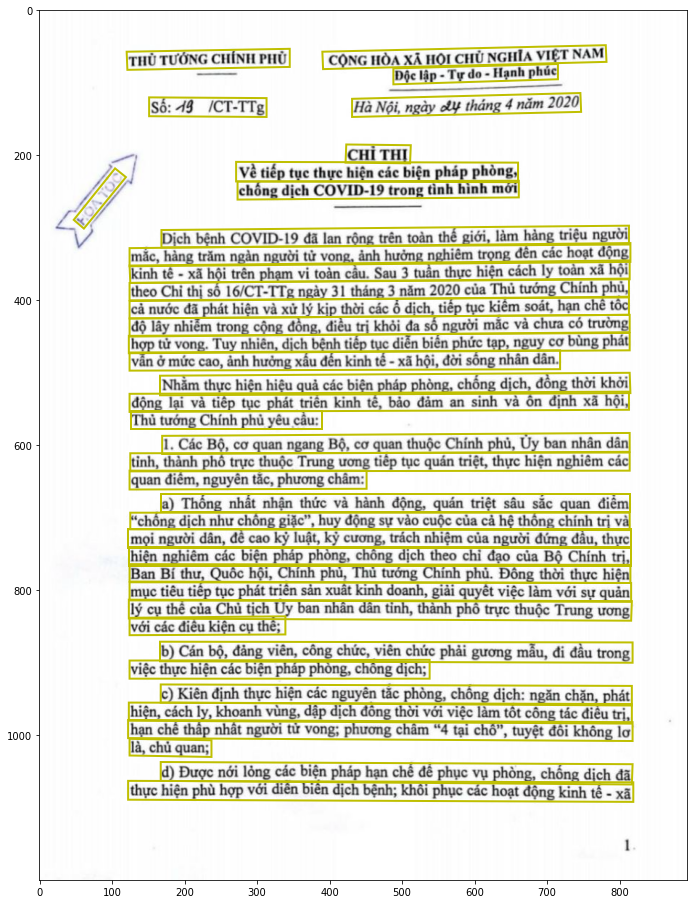

In [254]:
# TEST READ API

# import json
# import os
# import sys
# import requests
# import time
# # If you are using a Jupyter notebook, uncomment the following line.
# # %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon
# from PIL import Image
# from io import BytesIO

img_path = "../data/test_azure/gg_img11.jpg"
img_data = open(img_path, 'rb').read()
analysis = request_azure_read_api(img_data)

polygons = get_line_polygons_read_api(analysis)

# Display the image and overlay it with the extracted text.
# image = Image.open(BytesIO(requests.get(image_url).content))
image = cv2.imread(img_path)

show_polygons(image, polygons, figsize=(16,16), line_color='y')

In [249]:
bound = polygons[0]['boundingBox']
vertices = [(bound[i], bound[i+1])
                    for i in range(0, len(bound), 2)]
vertices

[(120, 57), (345, 53), (345, 78), (121, 82)]

In [243]:
bound

[120, 57, 345, 53, 345, 78, 121, 82]

[(120, 57), (345, 53), (345, 78), (121, 82)]

In [231]:
analysis

{'status': 'succeeded',
 'createdDateTime': '2020-12-08T18:40:58Z',
 'lastUpdatedDateTime': '2020-12-08T18:40:59Z',
 'analyzeResult': {'version': '3.0.0',
  'readResults': [{'page': 1,
    'angle': -0.0692,
    'width': 893,
    'height': 1200,
    'unit': 'pixel',
    'lines': [{'boundingBox': [120, 57, 345, 53, 345, 78, 121, 82],
      'text': 'THU TUONG CHINH PHU',
      'words': [{'boundingBox': [121, 58, 158, 57, 159, 81, 121, 82],
        'text': 'THU',
        'confidence': 0.721},
       {'boundingBox': [163, 57, 229, 55, 229, 80, 163, 81],
        'text': 'TUONG',
        'confidence': 0.877},
       {'boundingBox': [234, 55, 295, 54, 294, 79, 234, 80],
        'text': 'CHINH',
        'confidence': 0.885},
       {'boundingBox': [299, 54, 345, 53, 344, 79, 299, 79],
        'text': 'PHU',
        'confidence': 0.721}]},
     {'boundingBox': [390, 57, 781, 48, 782, 71, 391, 81],
      'text': 'CONG HOA XA HOI CHU NGHIA VIET NAM',
      'words': [{'boundingBox': [394, 58, 446, 

In [211]:
polygons

[([120, 57, 345, 53, 345, 78, 121, 82], 'THU TUONG CHINH PHU'),
 ([390, 57, 781, 48, 782, 71, 391, 81], 'CONG HOA XA HOI CHU NGHIA VIET NAM'),
 ([488, 80, 715, 74, 715, 95, 488, 102], 'Doc lap - Tu do - Hanh phuc'),
 ([151, 120, 313, 121, 313, 147, 151, 146], 'Só: 49 /CT-TTg'),
 ([431, 122, 746, 114, 747, 140, 431, 147],
  'Ha Noi, ngay oly thang 4 nam 2020'),
 ([423, 185, 512, 186, 511, 211, 422, 210], 'CHÌ THI'),
 ([271, 209, 660, 210, 660, 237, 271, 236],
  've tiep tue thic hien cac bien phap phong,'),
 ([47, 289, 104, 218, 119, 230, 61, 301], 'HOA TOC'),
 ([273, 236, 661, 235, 661, 258, 273, 261],
  'chong dich COVID-19 trong tinh hinh moi'),
 ([168, 303, 813, 297, 813, 323, 168, 327],
  'Dich benh COVID-19 da lan rong tren toan the gioi, lam hang trieu nguoi'),
 ([124, 328, 815, 321, 815, 347, 124, 353],
  'mac, hang tram ngan nguoi tu vong, anh huong nghiem trong den cac hoat dong'),
 ([124, 352, 814, 345, 814, 371, 125, 376],
  'kinh te - xa hoi tren pham vi toan cau. Sau 3 tua

In [207]:
analysis

{'status': 'succeeded',
 'createdDateTime': '2020-12-08T17:45:20Z',
 'lastUpdatedDateTime': '2020-12-08T17:45:26Z',
 'analyzeResult': {'version': '3.0.0',
  'readResults': [{'page': 1,
    'angle': -0.0692,
    'width': 893,
    'height': 1200,
    'unit': 'pixel',
    'lines': [{'boundingBox': [120, 57, 345, 53, 345, 78, 121, 82],
      'text': 'THU TUONG CHINH PHU',
      'words': [{'boundingBox': [121, 58, 158, 57, 159, 81, 121, 82],
        'text': 'THU',
        'confidence': 0.721},
       {'boundingBox': [163, 57, 229, 55, 229, 80, 163, 81],
        'text': 'TUONG',
        'confidence': 0.877},
       {'boundingBox': [234, 55, 295, 54, 294, 79, 234, 80],
        'text': 'CHINH',
        'confidence': 0.885},
       {'boundingBox': [299, 54, 345, 53, 344, 79, 299, 79],
        'text': 'PHU',
        'confidence': 0.721}]},
     {'boundingBox': [390, 57, 781, 48, 782, 71, 391, 81],
      'text': 'CONG HOA XA HOI CHU NGHIA VIET NAM',
      'words': [{'boundingBox': [394, 58, 446, 